In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import flopy
import matplotlib as mpl

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

if not os.path.exists("data"):
    os.mkdir("data")

3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
numpy version: 1.14.5
matplotlib version: 2.2.2
flopy version: 3.2.9


### Flow model data

In [2]:
nper, nstp, perlen, tsmult = 1, 1, 1., 1.
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220., 200., 0.]
laytyp = [1, 0, 0]
kh = [50., 0.01, 200.]
kv = [10., 0.01, 20.]
wel_loc = (2, 10, 9)
wel_q = -150000.
rch = 0.005
riv_h = 320.
riv_z = 317.
riv_c = 1.e5

### MODPATH 7 data

In [3]:
# MODPATH zones
zone3 = np.ones((nrow, ncol), dtype=np.int32)
zone3[wel_loc[1:]] = 2
zones = [1, 1, zone3]

# create particles
# particle group 1
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
part0 = flopy.modpath.LRCParticles.create_lrcparticles(v=plocs, drape=0,
                                                       particleids=pids)
pg0 = flopy.modpath.LRCParticles(particlegroupname='PG1', particledata=part0,
                                 filename='ex01a.pg1.sloc')

# particle group 2
v = [(2, 0, 0), (0, 20, 0)]
part1 = flopy.modpath.LRCParticles.create_lrcparticles(v=v, drape=1,
                                                       particleids=[1000, 1001])
pg1 = flopy.modpath.LRCParticles(particlegroupname='PG2', particledata=part1,
                                 filename='ex01a.pg2.sloc')

particlegroups = [pg0, pg1]

# default iface for MODFLOW-2005 and MODFLOW 6
defaultiface = {'RECHARGE': 6, 'ET': 6}
defaultiface6 = {'RCH': 6, 'EVT': 6}

### MODPATH 7 using MODFLOW-2005

#### Create and run MODFLOW-2005

In [4]:
ws = os.path.join('data', 'mp7_ex1', 'mf2005')
nm = 'ex01_mf2005'
exe_name = 'mf2005'
iu_cbc = 130
m = flopy.modflow.Modflow(nm, model_ws=ws,
                          exe_name=exe_name)
flopy.modflow.ModflowDis(m, nlay=nlay, nrow=nrow, ncol=ncol,
                         nper=nper, itmuni=4 , lenuni=1,
                         perlen=perlen, nstp=nstp,
                         tsmult=tsmult, steady=True,
                         delr=delr, delc=delc,
                         top=top, botm=botm)
flopy.modflow.ModflowLpf(m, ipakcb=iu_cbc, laytyp=laytyp, hk=kh, vka=kv)
flopy.modflow.ModflowBas(m, ibound=1, strt=top)
# recharge
flopy.modflow.ModflowRch(m, ipakcb=iu_cbc, rech=rch)
# wel
wd = [i for i in wel_loc] + [wel_q]
flopy.modflow.ModflowWel(m, ipakcb=iu_cbc, stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([0, i, ncol-1, riv_h, riv_c, riv_z])
flopy.modflow.ModflowRiv(m, ipakcb=iu_cbc, stress_period_data={0: rd})
# output control
flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ['save head',
                                                        'save budget',
                                                        'print head']})
flopy.modflow.ModflowPcg(m, hclose=1e-6, rclose=1e-6)

m.write_input()
success, buff = m.run_model()
assert success, 'mf2005 model did not run'

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ex01_mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/01 17:44:50

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/10/01 17:44:50
 Elapsed run time:  0.013 Seconds

  Normal termination of simulation


In [5]:
# this is a fix until the grid object is available
m.sr = flopy.utils.SpatialReference(xll=0, yll=0, delr=m.dis.delr.array, delc=m.dis.delc.array, 
                                    units='meters', lenuni=1, length_multiplier=1)

#### Create and run MODPATH 7

In [6]:
# create modpath files
exe_name = 'mp7'
mp = flopy.modpath.Modpath7(modelname=nm + '_mp', flowmodel=m,
                            exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1,
                                  defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  budgetcellnumbers=[1049, 1259],
                                  traceparticledata=[1, 1000],
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='extend',
                                  timepointdata=[500, 1000.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=particlegroups)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Sep 24 2018 14:08:42 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        23 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 output

In [7]:
fpth = os.path.join(ws, nm + '_mp.mppth')
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()
#p0 = p.get_data()

#### Plot MODPATH 7 output

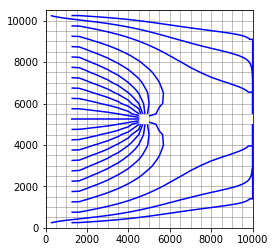

In [8]:
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(p0, layer='all', color='blue')

### MODPATH 7 using MODFLOW 6

#### Create and run MODFLOW 6

In [9]:
ws = os.path.join('data', 'mp7_ex1', 'mf6')
nm = 'ex01_mf6'
exe_name = 'mf6'

# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(sim_name=nm, exe_name='mf6',
                             version='mf6', sim_ws=ws)

# Create the Flopy temporal discretization object
pd = (perlen, nstp, tsmult)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis',
                                            time_units='DAYS', nper=nper,
                                            perioddata=[pd])

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(nm)
gwf = flopy.mf6.ModflowGwf(sim, modelname=nm,
                           model_nam_file=model_nam_file, save_flows=True)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', 
                                         complexity='SIMPLE',
                                         outer_hclose=1e-6,
                                         inner_hclose=1e-6,
                                         rcloserecord=1e-6)

# create gwf file
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nlay=nlay,
                                               nrow=nrow, ncol=ncol,
                                               length_units='FEET',
                                               delr=delr, delc=delc,
                                               top=top,
                                               botm=botm)
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=top)

# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf',
                                               icelltype=laytyp, k=kh,
                                               k33=kv)


# recharge
flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)
# wel
wd = [(wel_loc, wel_q)]
flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, maxbound=1,
                                         stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z])
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data={0: rd})
# Create the output control package
headfile = '{}.hds'.format(nm)
head_record = [headfile]
budgetfile = '{}.cbb'.format(nm)
budget_record = [budgetfile]
saverecord = [('HEAD', 'ALL'),
              ('BUDGET', 'ALL')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc',
                                            saverecord=saverecord,
                                            head_filerecord=head_record,
                                            budget_filerecord=budget_record)

# Write the datasets
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
assert success, 'mf6 model did not run'

Directory structure already exists for simulation path /Users/jdhughes/Documents/Development/flopy_git/examples/Notebooks/data/mp7_ex1/mf6
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.3 08/09/2018

  MODFLOW 6 compiled Sep 24 2018 16:09:01 with GFORTRAN compiler (ver. 6.4.0)

This software has been approved for release by the U.

#### Create and run MODPATH 7

In [10]:
# create modpath files
exe_name = 'mp7'
mp = flopy.modpath.Modpath7(modelname=nm + '_mp', flowmodel=gwf,
                            exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1,
                                  defaultiface=defaultiface6)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  budgetcellnumbers=[1049, 1259],
                                  traceparticledata=[1, 1000],
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='extend',
                                  timepointdata=[500, 1000.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=particlegroups)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Sep 24 2018 14:08:42 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        23 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 output

In [11]:
fpth = os.path.join(ws, nm + '_mp.mppth')
p = flopy.utils.PathlineFile(fpth)
p1 = p.get_alldata()

### Plot MODPATH 7 output

Use MODFLOW-2005 model for plotting (until MODFLOW 6 grid object implemented)

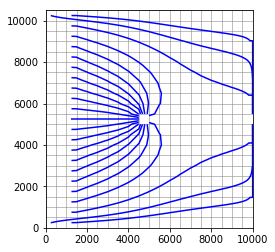

In [12]:
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(p1, layer='all', color='blue')

### Compare MODPATH results

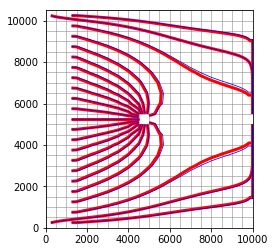

In [13]:
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(p1, layer='all', color='red', lw=3)
mm.plot_pathline(p0, layer='all', color='blue', lw=0.75)